In [15]:
import re
import pandas as pd
import time
import contextily as cx

In [16]:
df = pd.read_csv("scrap.csv",index_col=0)

#on isole les code postaux des noms de ville

df.ville = df.ville.str.replace("(","").str.replace(")","")
df.ville = df.ville.str.rstrip(" ")
df[["nom_ville", "code_postal"]] = df.ville.str.rsplit(" ", n=1, expand=True)
df.drop(["ville"] ,axis=1, inplace=True)

df["nom_ville"] = df["nom_ville"].str.strip()

#on supprime une ligne parasite

df = df.drop(992, axis=0)

#on code les code postaux de paris

df.code_postal = df.code_postal.astype(int)

df.code_postal = df.code_postal.apply(lambda x: x+75000 if x<75000 else x)

df.code_postal = df.code_postal.astype(str)

#on clean le nombre de pièces

df["nb de pièces"] = df["nb de pièces"].apply(lambda x: 2.5 if x=="2/3" else x)
df["nb de pièces"] = df["nb de pièces"].apply(lambda x: 3.5 if x=="3/4" else x)
df["nb de pièces"] = df["nb de pièces"].astype(int)
# on check les duplicatas

df.loc[df.duplicated(keep=False)]
df = df.drop_duplicates(ignore_index=True)

#on check les valeurs absurdes

# df.describe()

df.sort_values("taille").head(10)

#les biens à 1m& sont erronés

df.drop([2180, 2354] ,axis=0, inplace=True)



columns_titles = ["lien","type de bien","nb de pièces","taille","carrez","prix","nom_ville","code_postal"]
df=df.reindex(columns=columns_titles)
df

C:\Users\Syl\AppData\Local\Temp/ipykernel_19640/2276849589.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.ville = df.ville.str.replace("(","").str.replace(")","")


,lien,type de bien,nb de pièces,taille,carrez,prix,nom_ville,code_postal
0,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,4,67,False,269000,Vaires-sur-Marne,77360
1,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,4,91,False,420000,Palaiseau,91120
2,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,4,72,False,225000,Conflans-Sainte-Honorine,78700
3,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,58,False,210000,Villeneuve-Saint-Georges,94190
4,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,56,False,599000,Paris,75015
...,...,...,...,...,...,...,...,...
2413,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,65,False,263000,Champagne-sur-Oise,95660
2414,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,2,51,False,170000,Argenteuil,95100
2415,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,4,93,False,365000,Parmain,95620
2416,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,7,183,False,455000,Parmain,95620


In [17]:
df_villes = pd.read_csv(r"E:\villes_france.csv",header=None, index_col=0, low_memory=False)

#on garde les colonnes interessantes

df_codes_insee = df_villes.iloc[:,[4,7,9]]
df_codes_insee.columns = ["nom","code_postal","code_insee"]

#on garde que les cp des departements franciliens

df_codes_insee = df_codes_insee.loc[df_codes_insee["code_postal"].str.startswith(("75", "77", "78", "91", "92", "93", "94", "95"))]

#on split le cp de Paris

df_codes_insee["code_postal"] = df_codes_insee["code_postal"].str.split("-")
df_codes_insee = df_codes_insee.explode("code_postal").reset_index(drop=True)

df_codes_insee.index = range(len(df_codes_insee.index))

#correction des codes insee des arrondissements
for i in range(0,9) : 
    df_codes_insee["code_insee"][i] = "7510"+str(i+1)
for i in range(9,20) : 
    df_codes_insee["code_insee"][i] = "751"+str(i+1)

#Paris 16 2.0

df_codes_insee["code_insee"][20] = "75116"   


#df_codes_insee.loc[df_codes_insee.duplicated(keep=False, subset=['code_insee'])]

df_codes_insee


,nom,code_postal,code_insee
0,Paris,75001,75101
1,Paris,75002,75102
2,Paris,75003,75103
3,Paris,75004,75104
4,Paris,75005,75105
...,...,...,...
1300,Moisselles,95570,95409
1301,Vétheuil,95780,95651
1302,Villiers-Adam,95840,95678
1303,Maudétour-en-Vexin,95420,95379


In [18]:
import geopandas as gpd

gdf = gpd.read_file(r"H:\Work n shiet\Repo GitHub\ParuVendu\communes-ile-de-france.geojson")
gdf.sort_values("code")

,code,nom,geometry
302,75101,Paris 1er Arrondissement,"POLYGON ((2.32576 48.86955, 2.32787 48.86986, ..."
1274,75102,Paris 2e Arrondissement,"POLYGON ((2.35084 48.86334, 2.32787 48.86986, ..."
725,75103,Paris 3e Arrondissement,"POLYGON ((2.35009 48.86195, 2.35084 48.86334, ..."
455,75104,Paris 4e Arrondissement,"POLYGON ((2.34456 48.85399, 2.35009 48.86195, ..."
663,75105,Paris 5e Arrondissement,"POLYGON ((2.34456 48.85399, 2.36432 48.84617, ..."
...,...,...,...
724,95676,Villers-en-Arthies,"POLYGON ((1.70633 49.07775, 1.70386 49.07890, ..."
1035,95678,Villiers-Adam,"POLYGON ((2.23602 49.08745, 2.24972 49.08539, ..."
1199,95680,Villiers-le-Bel,"POLYGON ((2.41027 49.02399, 2.42512 49.01399, ..."
636,95682,Villiers-le-Sec,"POLYGON ((2.37040 49.07269, 2.39642 49.08649, ..."


In [20]:
#fusion des deux tables

df_geo = df_codes_insee.merge(gdf, how="inner", left_on="code_insee", right_on="code")


,nom_x,code_postal,code_insee,code,nom_y,geometry
0,Paris,75001,75101,75101,Paris 1er Arrondissement,"POLYGON ((2.32576 48.86955, 2.32787 48.86986, ..."
1,Paris,75002,75102,75102,Paris 2e Arrondissement,"POLYGON ((2.35084 48.86334, 2.32787 48.86986, ..."
2,Paris,75003,75103,75103,Paris 3e Arrondissement,"POLYGON ((2.35009 48.86195, 2.35084 48.86334, ..."
3,Paris,75004,75104,75104,Paris 4e Arrondissement,"POLYGON ((2.34456 48.85399, 2.35009 48.86195, ..."
4,Paris,75005,75105,75105,Paris 5e Arrondissement,"POLYGON ((2.34456 48.85399, 2.36432 48.84617, ..."
...,...,...,...,...,...,...
1297,Moisselles,95570,95409,95409,Moisselles,"POLYGON ((2.32195 49.05075, 2.33529 49.05147, ..."
1298,Vétheuil,95780,95651,95651,Vétheuil,"POLYGON ((1.72345 49.04497, 1.71710 49.04903, ..."
1299,Villiers-Adam,95840,95678,95678,Villiers-Adam,"POLYGON ((2.23602 49.08745, 2.24972 49.08539, ..."
1300,Maudétour-en-Vexin,95420,95379,95379,Maudétour-en-Vexin,"POLYGON ((1.79354 49.11485, 1.78202 49.10319, ..."


In [22]:
#correction de types

df['code_postal'] = df['code_postal'].astype(int)
df_geo['code_postal'] = df_geo['code_postal'].astype(int)

# on fusionne les deux tables pour donner la totalité

df_final = df.merge(df_geo, how="left", left_on=["code_postal"], right_on=["code_postal"])

df_final

,lien,type de bien,nb de pièces,taille,carrez,prix,nom_ville,code_postal,nom_x,code_insee,code,nom_y,geometry
0,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,4,67,False,269000,Vaires-sur-Marne,77360,Vaires-sur-Marne,77479,77479,Vaires-sur-Marne,"POLYGON ((2.66085 48.87404, 2.63847 48.85836, ..."
1,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,4,91,False,420000,Palaiseau,91120,Palaiseau,91477,91477,Palaiseau,"POLYGON ((2.20346 48.72105, 2.21290 48.72879, ..."
2,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,4,72,False,225000,Conflans-Sainte-Honorine,78700,Conflans-Sainte-Honorine,78172,78172,Conflans-Sainte-Honorine,"POLYGON ((2.07439 48.98480, 2.07188 48.99339, ..."
3,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,58,False,210000,Villeneuve-Saint-Georges,94190,Villeneuve-Saint-Georges,94078,94078,Villeneuve-Saint-Georges,"POLYGON ((2.42752 48.75101, 2.42659 48.76060, ..."
4,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,56,False,599000,Paris,75015,Paris,75115,75115,Paris 15e Arrondissement,"POLYGON ((2.28978 48.85812, 2.30219 48.85034, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6581,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,65,False,263000,Champagne-sur-Oise,95660,Champagne-sur-Oise,95134,95134,Champagne-sur-Oise,"POLYGON ((2.26362 49.13593, 2.25697 49.13184, ..."
6582,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,2,51,False,170000,Argenteuil,95100,Argenteuil,95018,95018,Argenteuil,"POLYGON ((2.29228 48.95139, 2.29097 48.95097, ..."
6583,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,4,93,False,365000,Parmain,95620,Parmain,95480,95480,Parmain,"POLYGON ((2.19846 49.15661, 2.20903 49.14578, ..."
6584,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,7,183,False,455000,Parmain,95620,Parmain,95480,95480,Parmain,"POLYGON ((2.19846 49.15661, 2.20903 49.14578, ..."


In [23]:
#on filtre les villes avec des code postaux multiples

df_final = df_final.loc[df_final["nom_ville"]==df_final["nom_x"]]


In [24]:
#convertion en gpd

df_final = gpd.GeoDataFrame(df_final, geometry='geometry')


0       4
1       4
2       4
3       3
4       3
       ..
6581    3
6582    2
6583    4
6584    7
6585    5
Name: nb de pièces, Length: 2363, dtype: int32

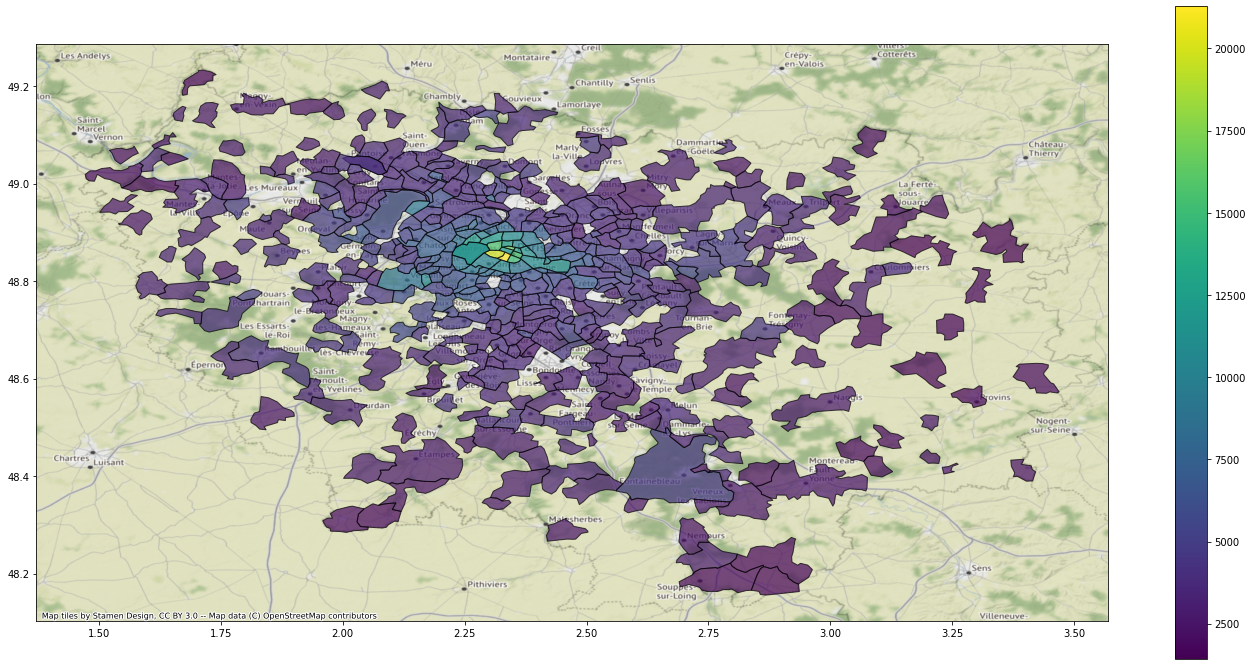

In [25]:
df_final["prix/m²"]= round(df_final["prix"]/df_final["taille"],1)
ax = df_final.dissolve(by = "code_postal", aggfunc="mean").plot(column="prix/m²", legend=True, alpha=0.7, figsize=(24, 12), edgecolor = 'k')

cx.add_basemap(ax, crs = df_final.crs)


In [26]:
#on sauvegarde

df_final.to_csv("table_totale_paru_vendu.csv")

In [30]:
#renaming pour coller au nom de la DB

df_final.columns = ['lien', 'type_de_bien', 'nb_de_pieces', 'superficie', 'carrez', 'prix',
       'nom_ville', 'code_postal', 'nom_x', 'code_insee',
       'code', 'nom_y', 'geometry', 'prix/m²']

In [31]:
#suppression des colonnes superflues

df_final = df_final.drop(["nom_x", "nom_y", "code"], axis = 1)

In [ ]:
#reindexing

df_final.index = range(len(df_final))

In [40]:
df_final

,lien,type de bien,nb_de_pieces,superficie,carrez,prix,nom_ville,code_postal,code_insee,geometry,prix/m²
0,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,4,67,False,269000,Vaires-sur-Marne,77360,77479,"POLYGON ((2.66085 48.87404, 2.63847 48.85836, ...",4014.9
1,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,4,91,False,420000,Palaiseau,91120,91477,"POLYGON ((2.20346 48.72105, 2.21290 48.72879, ...",4615.4
2,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,4,72,False,225000,Conflans-Sainte-Honorine,78700,78172,"POLYGON ((2.07439 48.98480, 2.07188 48.99339, ...",3125.0
3,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,58,False,210000,Villeneuve-Saint-Georges,94190,94078,"POLYGON ((2.42752 48.75101, 2.42659 48.76060, ...",3620.7
4,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,56,False,599000,Paris,75015,75115,"POLYGON ((2.28978 48.85812, 2.30219 48.85034, ...",10696.4
...,...,...,...,...,...,...,...,...,...,...,...
2358,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,3,65,False,263000,Champagne-sur-Oise,95660,95134,"POLYGON ((2.26362 49.13593, 2.25697 49.13184, ...",4046.2
2359,https://www.paruvendu.fr/immobilier/vente/appa...,Appartement,2,51,False,170000,Argenteuil,95100,95018,"POLYGON ((2.29228 48.95139, 2.29097 48.95097, ...",3333.3
2360,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,4,93,False,365000,Parmain,95620,95480,"POLYGON ((2.19846 49.15661, 2.20903 49.14578, ...",3924.7
2361,https://www.paruvendu.fr/immobilier/vente/mais...,Maison,7,183,False,455000,Parmain,95620,95480,"POLYGON ((2.19846 49.15661, 2.20903 49.14578, ...",2486.3


In [52]:
# encodage des id

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
df_final[["id_type"]] = enc.fit_transform(df_final[["type de bien"]])

enc = OrdinalEncoder()
df_final[["id_local"]] = enc.fit_transform(df_final[["code_insee"]])

In [51]:
#séparation en 3 tables

table_type = df_final[["type de bien" ,"id_type"]]
table_type = table_type.drop_duplicates()
table_type.to_csv("table_type.csv")

In [57]:
table_bien = df_final[["nb_de_pieces","superficie","carrez","prix","code_postal", "id_local","id_type"]]
table_bien = table_bien.drop_duplicates()
table_bien.to_csv("table_bien.csv")

In [58]:
#on crée la colonne departement

df_final["departement"]= df_final["code_postal"].astype(str).str[:2]

table_localisation = df_final[["id_local","code_insee","nom_ville", "departement","code_postal" ,"geometry"]]
table_localisation = table_localisation.drop_duplicates()
table_localisation.to_csv("table_localisation.csv")